In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
data_root = pathlib.Path('../../dataset/4500')

# save (img_path, label) pairs
train_csv_path = '../../csv/4500/train.csv'
val_csv_path = '../../csv/4500/val.csv'
test_csv_path = '../../csv/4500/test.csv'

In [3]:
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

BUFFER_SIZE = 100
BATCH_SIZE = 64

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

NUM_EPOCH = 10
LEARNING_RATE = 1e-5

In [4]:
# data_root = pathlib.Path('./dataset/4500')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif', 'bmp', 'ini')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)
# print(f'all image path = {all_image_paths}')

classes:
..\..\dataset\4500\owner
..\..\dataset\4500\shipper

total img num: 4500


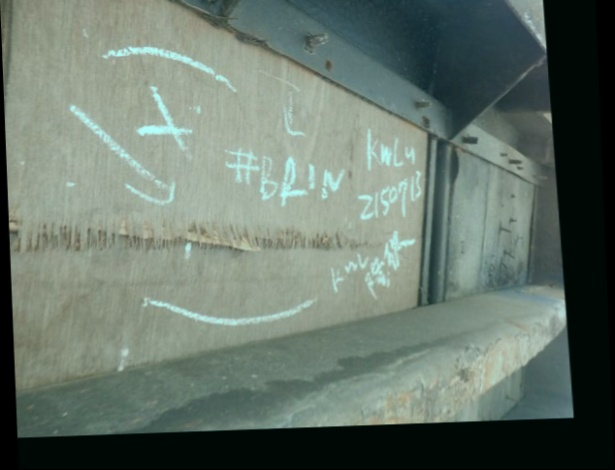

shipper


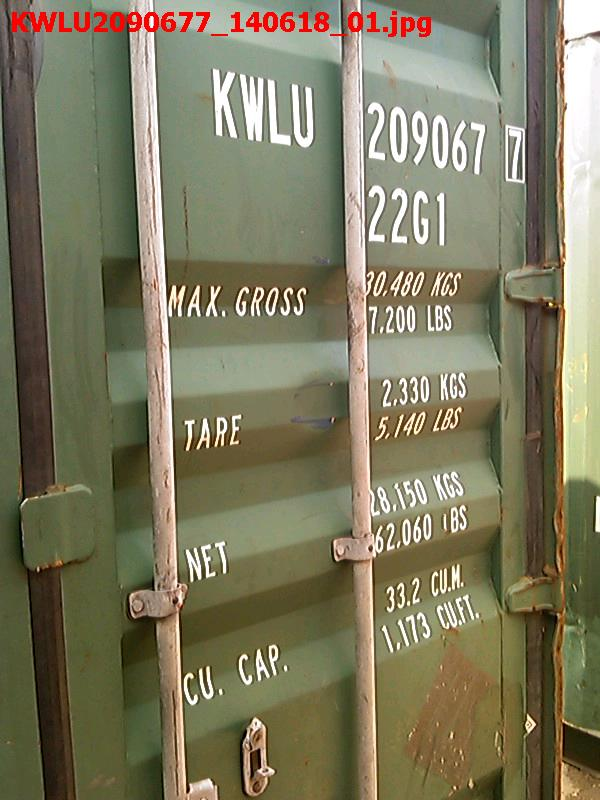

owner


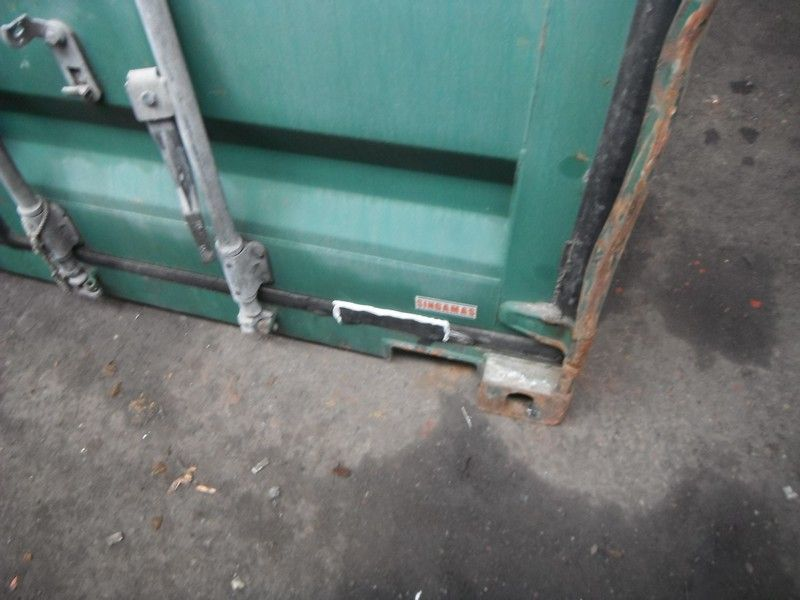

owner


In [5]:
# random showing 3 iamges 
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('\\')[-2])
    # print(image_path.split(os.path.sep)[-2])
    # print(image_path.split('/')[-2])

In [6]:
# get the label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

['owner', 'shipper']


In [7]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'owner': 0, 'shipper': 1}


In [8]:
# get the label data
all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [1, 1, 0, 0, 0, 1, 1, 0, 1, 0]


In [29]:
# Create (training + validation) : testing sets using an 90-10 split
img_path_train_and_val, img_path_test, label_train_and_val, label_test = train_test_split(all_image_paths, 
                                                                                          all_image_label,
                                                                                          test_size=0.1,
                                                                                          random_state=0)

print('training and validation data: %d'%(len(img_path_train_and_val)))
print('testing data: %d'%(len(img_path_test)))

training and validation data: 4050
testing data: 450


In [10]:
with open(test_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [11]:
class SimpleDataset(tf.data.Dataset):
    OUTPUT_SIGNATURE = (
        tf.TensorSpec(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(SimpleDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        img_paths, label = open_file(filename)

        # Reading the file
        for sample_idx in range(len(img_paths)):
            img = read_file(img_paths[sample_idx])
            yield img, label[sample_idx]

    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )


In [12]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(train_csv_path, *args):
    return SimpleDataset(train_csv_path, open_file, read_file)

def dataset_generator_fun_val(val_csv_path, *args):
    return SimpleDataset(val_csv_path, open_file, read_file)

def dataset_generator_fun_test(*args):
    return SimpleDataset(test_csv_path, open_file, read_file)

In [13]:
# parse training data
@tf.function
def map_fun(image, label):
    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    return distorted_image, label

# parse validation data
@tf.function
def map_fun_val(image, label):
    distorted_image = tf.image.per_image_standardization(image)

    return distorted_image, label

# parse testing data
@tf.function
def map_fun_test(image, label):
    distorted_image = tf.image.per_image_standardization(image)

    return distorted_image, label

(300, 300, 3)


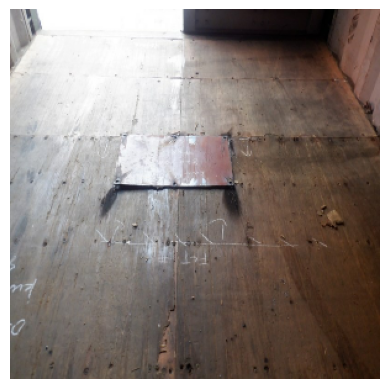

shipper
(300, 300, 3)


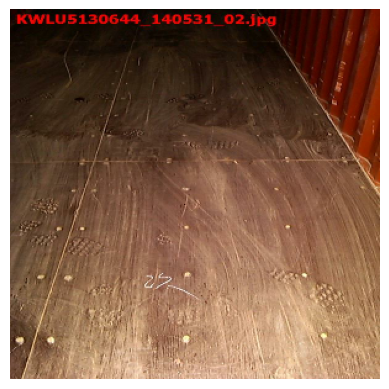

shipper
(300, 300, 3)


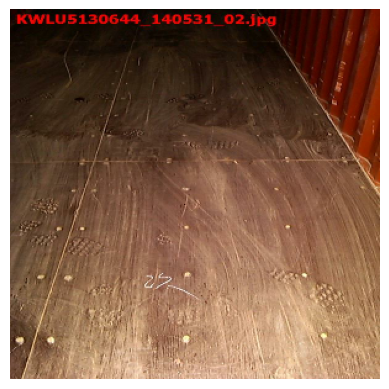

shipper
(300, 300, 3)


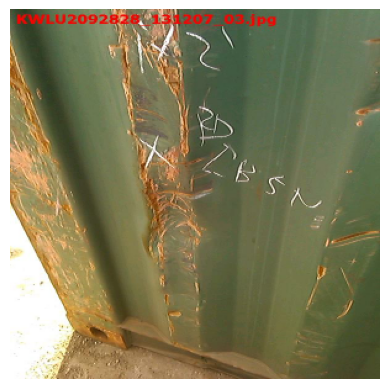

owner
(300, 300, 3)


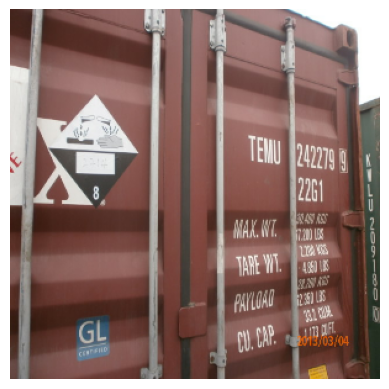

owner


In [14]:
from sklearn.model_selection import KFold

K = 5

# Create K-Fold object
kfold = KFold(n_splits=K, shuffle=True, random_state=SEED)  # K是你想要的折數

# Split data into K folds
fold_datasets_train = []
fold_datasets_val = []

for train_indices, val_indices in kfold.split(img_path_train_and_val, label_train_and_val):
    img_path_train_fold = [img_path_train_and_val[i] for i in train_indices]
    label_train_fold = [label_train_and_val[i] for i in train_indices]

    img_path_val_fold = [img_path_train_and_val[i] for i in val_indices]
    label_val_fold = [label_train_and_val[i] for i in val_indices]

    fold_datasets_train.append((img_path_train_fold, label_train_fold))
    fold_datasets_val.append((img_path_val_fold, label_val_fold))
    
dataset_train_fold_list = []
dataset_val_fold_list = []

for fold_idx, (train_data_fold, val_data_fold) in enumerate(zip(fold_datasets_train, fold_datasets_val)):
    
    img_path_train, label_train = train_data_fold
    img_path_val, label_val = val_data_fold
    
    # 重新創建CSV檔案
    train_csv_path_fold = f'../../csv/4500/train_fold_{fold_idx}.csv'
    val_csv_path_fold = f'../../csv/4500/val_fold_{fold_idx}.csv'

    with open(train_csv_path_fold, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['img_path', 'label'])
        for img_path, label in zip(img_path_train, label_train):
            writer.writerow([img_path, label])

    with open(val_csv_path_fold, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['img_path', 'label'])
        for img_path, label in zip(img_path_val, label_val):
            writer.writerow([img_path, label])

    # 使用新的CSV檔案創建相應的Dataset
    dataset_train_fold = tf.data.Dataset.range(1)\
                                        .interleave(lambda *args: dataset_generator_fun_train(train_csv_path_fold, *args), 
                                                    num_parallel_calls=tf.data.AUTOTUNE)\
                                        .shuffle(BUFFER_SIZE, seed=SEED)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .cache()\
                                        .prefetch(tf.data.AUTOTUNE)
    dataset_train_fold_list.append(dataset_train_fold)

    dataset_val_fold = tf.data.Dataset.range(1)\
                                       .interleave(lambda *args: dataset_generator_fun_val(val_csv_path_fold, *args), 
                                                   num_parallel_calls=tf.data.AUTOTUNE)\
                                       .shuffle(BUFFER_SIZE, seed=SEED)\
                                       .batch(BATCH_SIZE, drop_remainder=True)\
                                       .cache()\
                                       .prefetch(tf.data.AUTOTUNE)
    dataset_val_fold_list.append(dataset_val_fold)
    
for dataset_train_fold in dataset_train_fold_list:
    for img, label in dataset_train_fold.take(1):
        print(img[0].shape)
        plt.imshow(img[0]) 
        plt.axis('off') 
        plt.show()
        print(index_to_label[label[0].numpy()])

In [15]:
dataset_test = tf.data.Dataset.range(1)\
                              .interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                              .batch(BATCH_SIZE, drop_remainder=True)\
                              .cache()\
                              .prefetch(tf.data.AUTOTUNE)

In [16]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [17]:
wild_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [18]:
# save the initialization of weights 
# wild_model.save_weights('../../weight/WildModel/wild_model.h5')

In [19]:
# define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [20]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))
    
#     print("Label shape:", label.shape)
#     print("Predictions shape:", predictions.shape)

    train_loss(loss)
    train_accuracy(label, predictions)
    
@tf.function
def val_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    val_loss(loss)
    val_accuracy(label, predictions)
    
@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    return loss, label, predictions

In [21]:
train_loss_list = []
val_loss_list = []

train_acc_list = []
val_acc_list = []

best_val_acc = 0
best_val_epoch = 0
best_val_fold = 0

def epoch_loop(dataset_train_fold_list, dataset_val_fold_list, EPOCHS):
    for epoch in range(EPOCHS):
        
        train_loss_fold_list = []
        val_loss_fold_list = []
        
        train_acc_fold_list = []
        val_acc_fold_list = []
        
        for i in range(K):
            # Reset the metrics at the start of the next epoch
            train_loss.reset_states()
            train_accuracy.reset_states()
            val_loss.reset_states()
            val_accuracy.reset_states()

            tf.print("training:")
            t = tqdm(dataset_train_fold_list[i], total=math.floor(len(img_path_train)//BATCH_SIZE))
            for image, label in t:
                train_step(image, label)
            t.close()

            tf.print("validating:")
            t = tqdm(dataset_val_fold_list[i], total=math.floor(len(img_path_val)//BATCH_SIZE))
            for image, label in t:
                val_step(image, label)
            t.close()

            train_loss_fold_list.append(train_loss.result().numpy())
            val_loss_fold_list.append(val_loss.result().numpy())
            
            train_acc_fold_list.append(train_accuracy.result()*100)
            val_acc_fold_list.append(val_accuracy.result()*100)

            template = 'Epoch {:0}, Fold {:0}, Training loss: {:.4f}, Training accuracy: {:.4f}, Validation loss: {:.4f}, Validation Accuracy: {:.4f}'
            tf.print (template.format(epoch+1,
                                   i+1,   
                                   train_loss.result(),
                                   train_accuracy.result()*100,
                                   val_loss.result(),
                                   val_accuracy.result()*100))
            
            global best_val_acc
            global best_val_epoch
            global best_val_fold
            if val_accuracy.result()*100 > best_val_acc:
                best_val_acc = val_accuracy.result()*100
                best_val_epoch = epoch+1
                best_val_fold = i+1
            
            # Save weights per fold 
            wild_model.save_weights('../../weight/WildModel/wild_model_epoch_{}_fold_{}.h5'.format(epoch+1, i+1), overwrite=True)
        
        train_loss_list.append(np.mean(train_loss_fold_list, axis=0))
        val_loss_list.append(np.mean(val_loss_fold_list, axis=0))
        
        train_acc_list.append(np.mean(train_acc_fold_list, axis=0))
        val_acc_list.append(np.mean(val_acc_fold_list, axis=0))
        
        template = 'Epoch {:0}, Avg training loss: {:.4f}, Avg training accuracy: {:.4f}, Avg validation loss: {:.4f}, Avg validation Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,  
                                   train_loss_list[-1],
                                   train_acc_list[-1],
                                   val_loss_list[-1],
                                   val_acc_list[-1]))

In [22]:
# wild_model.load_weights('../../weight/WildModel/wild_model.h5')
epoch_loop(dataset_train_fold_list, dataset_val_fold_list, EPOCHS= NUM_EPOCH)

training:


100%|██████████| 50/50 [03:47<00:00,  4.55s/it]

validating:



100%|██████████| 12/12 [00:48<00:00,  4.07s/it]

Epoch 1, Fold 1, Training loss: 0.4525, Training accuracy: 79.5312, Validation loss: 0.2671, Validation Accuracy: 89.5833


training:


100%|██████████| 50/50 [03:40<00:00,  4.40s/it]

validating:



100%|██████████| 12/12 [00:51<00:00,  4.26s/it]

Epoch 1, Fold 2, Training loss: 0.3074, Training accuracy: 86.9062, Validation loss: 0.2127, Validation Accuracy: 91.7969


training:


100%|██████████| 50/50 [03:52<00:00,  4.64s/it]

validating:



100%|██████████| 12/12 [00:50<00:00,  4.22s/it]

Epoch 1, Fold 3, Training loss: 0.2544, Training accuracy: 89.9688, Validation loss: 0.1913, Validation Accuracy: 91.9271


training:


100%|██████████| 50/50 [03:47<00:00,  4.54s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  4.00s/it]

Epoch 1, Fold 4, Training loss: 0.2233, Training accuracy: 90.5000, Validation loss: 0.1742, Validation Accuracy: 92.5781


training:


100%|██████████| 50/50 [03:39<00:00,  4.39s/it]

validating:



100%|██████████| 12/12 [00:48<00:00,  4.04s/it]

Epoch 1, Fold 5, Training loss: 0.2114, Training accuracy: 91.4688, Validation loss: 0.1223, Validation Accuracy: 95.3125


Epoch 1, Avg training loss: 0.2898, Avg training accuracy: 87.6750, Avg validation loss: 0.1935, Avg validation Accuracy: 92.2396
training:


100%|██████████| 50/50 [03:39<00:00,  4.40s/it]

validating:



100%|██████████| 12/12 [00:48<00:00,  4.02s/it]

Epoch 2, Fold 1, Training loss: 0.1807, Training accuracy: 92.3750, Validation loss: 0.1498, Validation Accuracy: 94.1406


training:


100%|██████████| 50/50 [03:38<00:00,  4.38s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.95s/it]

Epoch 2, Fold 2, Training loss: 0.1764, Training accuracy: 92.4688, Validation loss: 0.1361, Validation Accuracy: 94.1406


training:


100%|██████████| 50/50 [03:36<00:00,  4.34s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.99s/it]

Epoch 2, Fold 3, Training loss: 0.1641, Training accuracy: 92.9375, Validation loss: 0.1317, Validation Accuracy: 94.0104


training:


100%|██████████| 50/50 [03:37<00:00,  4.35s/it]

validating:



100%|██████████| 12/12 [00:48<00:00,  4.03s/it]

Epoch 2, Fold 4, Training loss: 0.1547, Training accuracy: 93.9062, Validation loss: 0.1145, Validation Accuracy: 94.7917


training:


100%|██████████| 50/50 [03:37<00:00,  4.36s/it]

validating:



100%|██████████| 12/12 [00:48<00:00,  4.06s/it]

Epoch 2, Fold 5, Training loss: 0.1471, Training accuracy: 93.8750, Validation loss: 0.0780, Validation Accuracy: 97.2656


Epoch 2, Avg training loss: 0.1646, Avg training accuracy: 93.1125, Avg validation loss: 0.1220, Avg validation Accuracy: 94.8698
training:


100%|██████████| 50/50 [03:39<00:00,  4.39s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  4.00s/it]

Epoch 3, Fold 1, Training loss: 0.1209, Training accuracy: 95.0938, Validation loss: 0.0994, Validation Accuracy: 96.0938


training:


100%|██████████| 50/50 [03:37<00:00,  4.36s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.95s/it]

Epoch 3, Fold 2, Training loss: 0.1152, Training accuracy: 95.4375, Validation loss: 0.0864, Validation Accuracy: 96.6146


training:


100%|██████████| 50/50 [03:39<00:00,  4.38s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.93s/it]

Epoch 3, Fold 3, Training loss: 0.1040, Training accuracy: 95.9375, Validation loss: 0.0831, Validation Accuracy: 96.4844


training:


100%|██████████| 50/50 [03:37<00:00,  4.34s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.96s/it]

Epoch 3, Fold 4, Training loss: 0.1090, Training accuracy: 95.1875, Validation loss: 0.0744, Validation Accuracy: 96.7448


training:


100%|██████████| 50/50 [03:40<00:00,  4.40s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.97s/it]

Epoch 3, Fold 5, Training loss: 0.0950, Training accuracy: 96.5938, Validation loss: 0.0459, Validation Accuracy: 98.9583


Epoch 3, Avg training loss: 0.1088, Avg training accuracy: 95.6500, Avg validation loss: 0.0778, Avg validation Accuracy: 96.9792
training:


100%|██████████| 50/50 [03:40<00:00,  4.41s/it]

validating:



100%|██████████| 12/12 [00:48<00:00,  4.05s/it]

Epoch 4, Fold 1, Training loss: 0.0836, Training accuracy: 96.5938, Validation loss: 0.0504, Validation Accuracy: 98.0469


training:


100%|██████████| 50/50 [03:39<00:00,  4.38s/it]

validating:



100%|██████████| 12/12 [00:49<00:00,  4.16s/it]

Epoch 4, Fold 2, Training loss: 0.0817, Training accuracy: 96.6875, Validation loss: 0.0519, Validation Accuracy: 98.4375


training:


100%|██████████| 50/50 [03:40<00:00,  4.42s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.99s/it]

Epoch 4, Fold 3, Training loss: 0.0702, Training accuracy: 97.4375, Validation loss: 0.0454, Validation Accuracy: 98.4375


training:


100%|██████████| 50/50 [03:38<00:00,  4.37s/it]

validating:



100%|██████████| 12/12 [00:48<00:00,  4.05s/it]

Epoch 4, Fold 4, Training loss: 0.0628, Training accuracy: 97.7812, Validation loss: 0.0383, Validation Accuracy: 98.1771


training:


100%|██████████| 50/50 [03:40<00:00,  4.41s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.95s/it]

Epoch 4, Fold 5, Training loss: 0.0645, Training accuracy: 97.7188, Validation loss: 0.0261, Validation Accuracy: 99.3490


Epoch 4, Avg training loss: 0.0726, Avg training accuracy: 97.2438, Avg validation loss: 0.0424, Avg validation Accuracy: 98.4896
training:


100%|██████████| 50/50 [03:38<00:00,  4.36s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.98s/it]

Epoch 5, Fold 1, Training loss: 0.0546, Training accuracy: 98.1250, Validation loss: 0.0258, Validation Accuracy: 99.4792


training:


100%|██████████| 50/50 [03:38<00:00,  4.37s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.97s/it]

Epoch 5, Fold 2, Training loss: 0.0526, Training accuracy: 98.0625, Validation loss: 0.0280, Validation Accuracy: 99.6094


training:


100%|██████████| 50/50 [03:39<00:00,  4.39s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.98s/it]

Epoch 5, Fold 3, Training loss: 0.0403, Training accuracy: 98.9062, Validation loss: 0.0286, Validation Accuracy: 99.2188


training:


100%|██████████| 50/50 [03:38<00:00,  4.38s/it]

validating:



100%|██████████| 12/12 [00:48<00:00,  4.05s/it]

Epoch 5, Fold 4, Training loss: 0.0437, Training accuracy: 98.5000, Validation loss: 0.0197, Validation Accuracy: 99.7396


training:


100%|██████████| 50/50 [03:36<00:00,  4.33s/it]

validating:



100%|██████████| 12/12 [00:48<00:00,  4.04s/it]

Epoch 5, Fold 5, Training loss: 0.0413, Training accuracy: 98.5625, Validation loss: 0.0146, Validation Accuracy: 99.4792


Epoch 5, Avg training loss: 0.0465, Avg training accuracy: 98.4313, Avg validation loss: 0.0233, Avg validation Accuracy: 99.5052
training:


100%|██████████| 50/50 [03:36<00:00,  4.34s/it]

validating:



100%|██████████| 12/12 [00:48<00:00,  4.02s/it]

Epoch 6, Fold 1, Training loss: 0.0333, Training accuracy: 99.2500, Validation loss: 0.0123, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [03:37<00:00,  4.36s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.96s/it]

Epoch 6, Fold 2, Training loss: 0.0315, Training accuracy: 99.0312, Validation loss: 0.0172, Validation Accuracy: 99.7396


training:


100%|██████████| 50/50 [03:37<00:00,  4.35s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.95s/it]

Epoch 6, Fold 3, Training loss: 0.0268, Training accuracy: 99.3125, Validation loss: 0.0142, Validation Accuracy: 99.7396


training:


100%|██████████| 50/50 [03:40<00:00,  4.41s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.93s/it]

Epoch 6, Fold 4, Training loss: 0.0283, Training accuracy: 99.1562, Validation loss: 0.0126, Validation Accuracy: 99.7396


training:


100%|██████████| 50/50 [03:36<00:00,  4.33s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.94s/it]

Epoch 6, Fold 5, Training loss: 0.0243, Training accuracy: 99.3750, Validation loss: 0.0082, Validation Accuracy: 99.8698


Epoch 6, Avg training loss: 0.0288, Avg training accuracy: 99.2250, Avg validation loss: 0.0129, Avg validation Accuracy: 99.8177
training:


100%|██████████| 50/50 [03:41<00:00,  4.44s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  4.00s/it]

Epoch 7, Fold 1, Training loss: 0.0209, Training accuracy: 99.5312, Validation loss: 0.0068, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [03:37<00:00,  4.35s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.99s/it]

Epoch 7, Fold 2, Training loss: 0.0195, Training accuracy: 99.5938, Validation loss: 0.0077, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [03:36<00:00,  4.34s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.99s/it]

Epoch 7, Fold 3, Training loss: 0.0183, Training accuracy: 99.5938, Validation loss: 0.0082, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [03:37<00:00,  4.34s/it]

validating:



100%|██████████| 12/12 [00:48<00:00,  4.03s/it]

Epoch 7, Fold 4, Training loss: 0.0167, Training accuracy: 99.5625, Validation loss: 0.0064, Validation Accuracy: 99.8698


training:


100%|██████████| 50/50 [03:37<00:00,  4.34s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.99s/it]

Epoch 7, Fold 5, Training loss: 0.0174, Training accuracy: 99.4688, Validation loss: 0.0051, Validation Accuracy: 100.0000


Epoch 7, Avg training loss: 0.0186, Avg training accuracy: 99.5500, Avg validation loss: 0.0068, Avg validation Accuracy: 99.9740
training:


100%|██████████| 50/50 [03:37<00:00,  4.36s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  4.00s/it]

Epoch 8, Fold 1, Training loss: 0.0136, Training accuracy: 99.7188, Validation loss: 0.0055, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [03:39<00:00,  4.39s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.99s/it]

Epoch 8, Fold 2, Training loss: 0.0133, Training accuracy: 99.7188, Validation loss: 0.0053, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [03:37<00:00,  4.35s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.93s/it]

Epoch 8, Fold 3, Training loss: 0.0134, Training accuracy: 99.7188, Validation loss: 0.0048, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [03:38<00:00,  4.36s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  4.00s/it]

Epoch 8, Fold 4, Training loss: 0.0105, Training accuracy: 99.8750, Validation loss: 0.0061, Validation Accuracy: 99.8698


training:


100%|██████████| 50/50 [03:36<00:00,  4.34s/it]

validating:



100%|██████████| 12/12 [00:48<00:00,  4.03s/it]

Epoch 8, Fold 5, Training loss: 0.0107, Training accuracy: 99.7500, Validation loss: 0.0042, Validation Accuracy: 100.0000


Epoch 8, Avg training loss: 0.0123, Avg training accuracy: 99.7562, Avg validation loss: 0.0052, Avg validation Accuracy: 99.9740
training:


100%|██████████| 50/50 [03:37<00:00,  4.35s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  4.00s/it]

Epoch 9, Fold 1, Training loss: 0.0095, Training accuracy: 99.9375, Validation loss: 0.0034, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [03:36<00:00,  4.34s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.95s/it]

Epoch 9, Fold 2, Training loss: 0.0102, Training accuracy: 99.7500, Validation loss: 0.0074, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [03:37<00:00,  4.35s/it]

validating:



100%|██████████| 12/12 [00:47<00:00,  3.96s/it]

Epoch 9, Fold 3, Training loss: 0.0090, Training accuracy: 99.8750, Validation loss: 0.0029, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [03:43<00:00,  4.47s/it]

validating:



100%|██████████| 12/12 [00:52<00:00,  4.39s/it]

Epoch 9, Fold 4, Training loss: 0.0115, Training accuracy: 99.7500, Validation loss: 0.0030, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [04:12<00:00,  5.04s/it]

validating:



100%|██████████| 12/12 [00:53<00:00,  4.45s/it]

Epoch 9, Fold 5, Training loss: 0.0087, Training accuracy: 99.8750, Validation loss: 0.0047, Validation Accuracy: 100.0000


Epoch 9, Avg training loss: 0.0098, Avg training accuracy: 99.8375, Avg validation loss: 0.0043, Avg validation Accuracy: 100.0000
training:


100%|██████████| 50/50 [03:58<00:00,  4.77s/it]

validating:



100%|██████████| 12/12 [00:51<00:00,  4.28s/it]

Epoch 10, Fold 1, Training loss: 0.0098, Training accuracy: 99.8125, Validation loss: 0.0033, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [04:07<00:00,  4.96s/it]

validating:



100%|██████████| 12/12 [00:52<00:00,  4.40s/it]

Epoch 10, Fold 2, Training loss: 0.0068, Training accuracy: 99.9062, Validation loss: 0.0026, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [03:47<00:00,  4.54s/it]

validating:



100%|██████████| 12/12 [00:48<00:00,  4.03s/it]

Epoch 10, Fold 3, Training loss: 0.0064, Training accuracy: 99.9688, Validation loss: 0.0031, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [03:46<00:00,  4.52s/it]

validating:



100%|██████████| 12/12 [00:49<00:00,  4.09s/it]

Epoch 10, Fold 4, Training loss: 0.0060, Training accuracy: 99.9375, Validation loss: 0.0032, Validation Accuracy: 100.0000


training:


100%|██████████| 50/50 [03:48<00:00,  4.57s/it]

validating:



100%|██████████| 12/12 [00:49<00:00,  4.12s/it]

Epoch 10, Fold 5, Training loss: 0.0052, Training accuracy: 99.9375, Validation loss: 0.0015, Validation Accuracy: 100.0000


Epoch 10, Avg training loss: 0.0068, Avg training accuracy: 99.9125, Avg validation loss: 0.0027, Avg validation Accuracy: 100.0000


In [26]:
wild_model.load_weights(f'../../weight/WildModel/wild_model_epoch_{best_val_epoch}_fold_{best_val_fold}.h5')

true_label = []
predicted_label = []

def test_loop(dataset_test):
    for image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
        loss, labels, predictions = test_step(image, label)
        
        true_label.extend(labels.numpy())
        predicted_label.extend(tf.argmax(predictions, axis=1).numpy())
        
        test_loss(loss)
        test_accuracy(labels, predictions)

    template = 'Test loss: {:.4f}, Test accuracy: {:.4f}'
    tf.print(template.format(test_loss.result(), test_accuracy.result()*100))

test_loop(dataset_test)

100%|██████████| 7/7 [00:31<00:00,  4.48s/it]

Test loss: 0.1675, Test accuracy: 94.1964


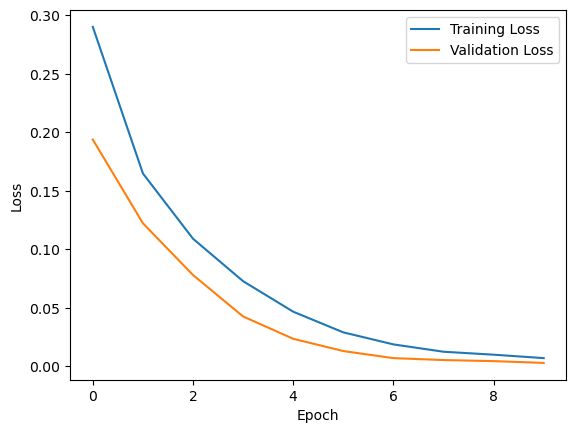

In [27]:
# Plot training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

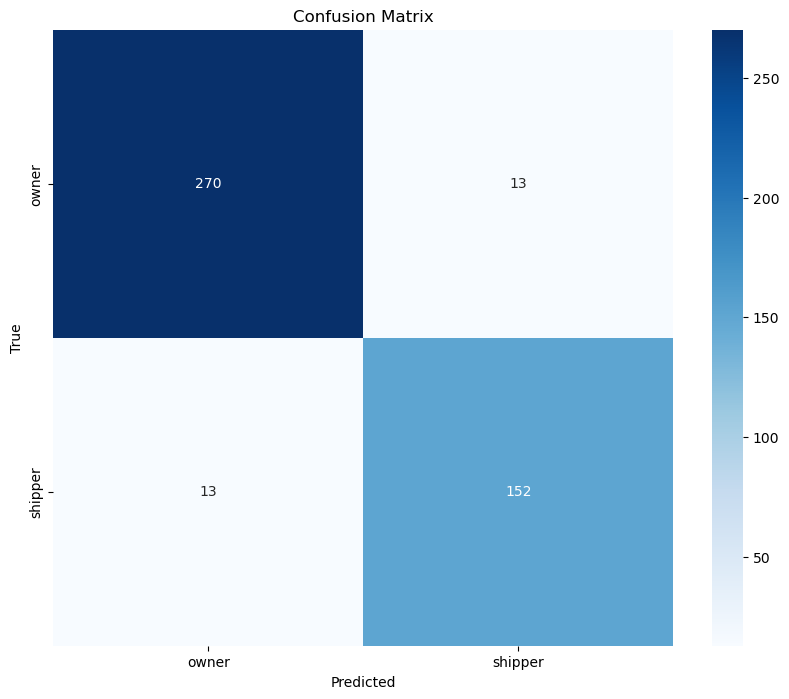

In [28]:
cm = confusion_matrix(true_label, predicted_label)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()